# Optical Character Recognition

*Gibran Ariq Natakusuma 1301213180*

### Import Libraries

In [1]:
# Default libraries, packages for data management, visualization and Computer vision libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Sklearn Packages
import sklearn
from sklearn.metrics import confusion_matrix,classification_report

# Tensorflow Packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image


### Data Loading

In [2]:
main_path = "/kaggle/input/handwriting/data"

# Load training data
train_data_dir = os.path.join(main_path, 'training_data')
train_df = train_data_dir

# Load testing data
test_data_dir = os.path.join(main_path, 'testing_data')
test_df = test_data_dir

#### Set Hyperparameter

In [3]:
batch_size = 32
IMG_HEIGHT = 28
IMG_WIDTH = 28

### Augmentation

Kami mendefinisikan dua data generator, satu yang menambah data untuk membuat pelatihan kami lebih umum dan satu lagi yang hanya menskalakan dan memusatkan data.

In [5]:
augmented_image_gen = ImageDataGenerator(
    rescale = 1/255.0,
    width_shift_range=.1,
    height_shift_range=.1,
    zoom_range=0.1,
    shear_range=0.5,
    brightness_range=[0.9, 1.1],
    validation_split=0.2,
   
   )

normal_image_gen1 = ImageDataGenerator(
    rescale = 1/255.0,
    validation_split=0.2,
  
   )


normal_image_gen2 = ImageDataGenerator(
    rescale = 1/255.0
  
   )

In [6]:
train_data_gen = augmented_image_gen.flow_from_directory(train_df,
                                                     batch_size=batch_size,
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867,
                                                     subset='training')
val_data_gen = normal_image_gen1.flow_from_directory(train_df,
                                                     batch_size=batch_size,
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867,
                                                     subset='validation')
test_data_gen = normal_image_gen2.flow_from_directory(test_df,
                                                     batch_size=batch_size,
                                                     color_mode="grayscale",
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867)



Found 16524 images belonging to 36 classes.
Found 4104 images belonging to 36 classes.
Found 1008 images belonging to 36 classes.


#### Image Samples

In [7]:
def plot_images(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.reshape(imageWidth, imageHeight), cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


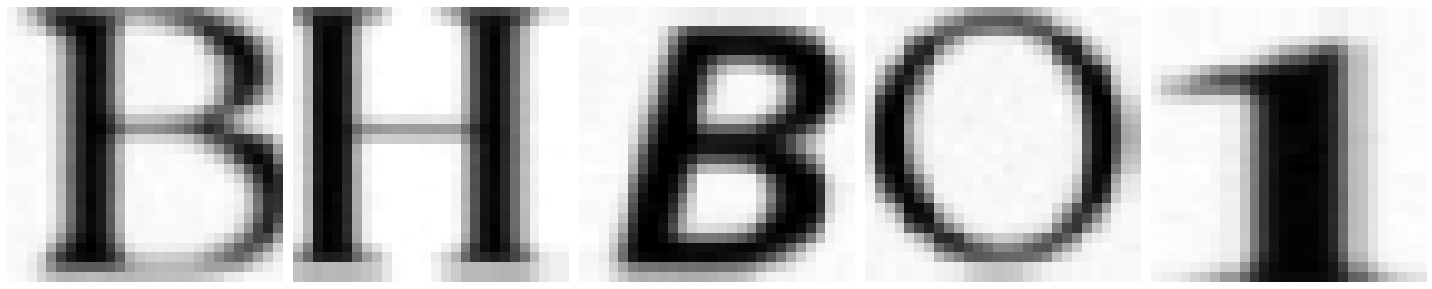

In [8]:
sample_training_images, _ = next(iter(train_data_gen))
plot_images(sample_training_images[:5], IMG_WIDTH, IMG_HEIGHT)

### Creating Model 

In [9]:
# # define cnn model
# def define_model():
#     model = Sequential()
#     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Flatten())
#     model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
#     model.add(Dense(36, activation='softmax'))
#     return model

def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(36, activation='softmax'))
    return model

In [10]:
model = define_model()

#### Callback

In [11]:
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
# #Prepare call backs
# def my_callback(model_name):
#     EarlyStop_callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
#     checkpoint = ModelCheckpoint(f'{model_name}_model.keras',
#                                  monitor = 'val_loss',mode = 'min',save_best_only= True)
#     return [EarlyStop_callback,checkpoint]

def my_callback(model_name):
    early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'{model_name}_model.keras',
                                 monitor='val_loss', mode='min', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    return [early_stop, checkpoint, reduce_lr]

### Training Model

In [12]:
model.compile(optimizer=SGD(lr=0.01, momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=32,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks = my_callback("hehe"))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/32
516/516 [==============================] - 97s 170ms/step - loss: 2.8647 - categorical_accuracy: 0.2124 - val_loss: 0.5734 - val_categorical_accuracy: 0.8682
Epoch 2/32
516/516 [==============================] - 26s 51ms/step - loss: 1.0020 - categorical_accuracy: 0.6863 - val_loss: 0.3236 - val_categorical_accuracy: 0.9077
Epoch 3/32
516/516 [==============================] - 29s 56ms/step - loss: 0.6997 - categorical_accuracy: 0.7733 - val_loss: 0.3050 - val_categorical_accuracy: 0.9128
Epoch 4/32
516/516 [==============================] - 29s 56ms/step - loss: 0.5796 - categorical_accuracy: 0.8175 - val_loss: 0.2580 - val_categorical_accuracy: 0.9229
Epoch 5/32
516/516 [==============================] - 26s 51ms/step - loss: 0.5061 - categorical_accuracy: 0.8435 - val_loss: 0.2018 - val_categorical_accuracy: 0.9346
Epoch 6/32
516/516 [==============================] - 26s 51ms/step - loss: 0.4717 - categorical_accuracy: 0.8534 - val_loss: 0.2081 - val_categorical_accuracy

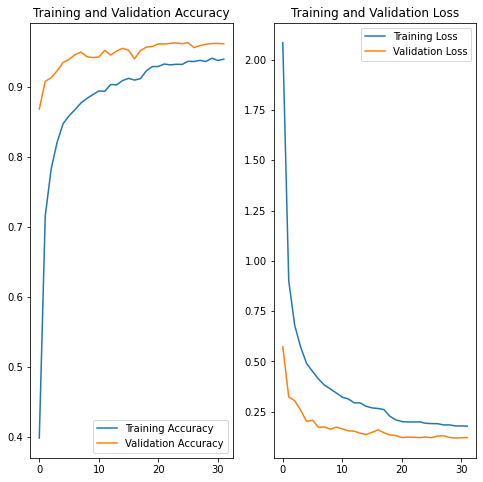

In [13]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']



val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
loss, accuracy= model.evaluate(val_data_gen, steps=val_data_gen.samples // val_data_gen.batch_size)
print(f"Model Validation Accuracy: {accuracy* 100:.2f}%")

128/128 [==============================] - 3s 26ms/step - loss: 0.1214 - categorical_accuracy: 0.9617
Model Validation Accuracy: 96.17%


In [15]:
# Evaluasi Model pada Set Testing
test_loss, test_accuracy = model.evaluate(test_data_gen, steps=test_data_gen.samples // batch_size)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Prediksi pada Set Testing
test_data_gen.reset()
predictions = model.predict(test_data_gen, steps=test_data_gen.samples // batch_size, verbose=1)

# Konversi prediksi dari probabilitas ke kelas indeks
predicted_classes = np.argmax(predictions, axis=1)

# Ambil label asli dari set testing
true_classes = test_data_gen.classes[:len(predicted_classes)]
class_labels = list(test_data_gen.class_indices.keys())

# Laporan Klasifikasi
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

31/31 [==============================] - 4s 131ms/step - loss: 0.0673 - categorical_accuracy: 0.9738
Test Loss: 0.06727622449398041
Test Accuracy: 0.9737903475761414
31/31 [==============================] - 1s 24ms/step
              precision    recall  f1-score   support

           0       0.57      0.89      0.69        28
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00        28
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        28
           8       1.00      1.00      1.00        28
           9       1.00      1.00      1.00        28
           A       1.00      1.00      1.00        28
           B       1.00      1.00      1.00        28
           C       0.96      0.96      0.96        28
           D       1.00

### Model Testing

Number of misclassified images: 26


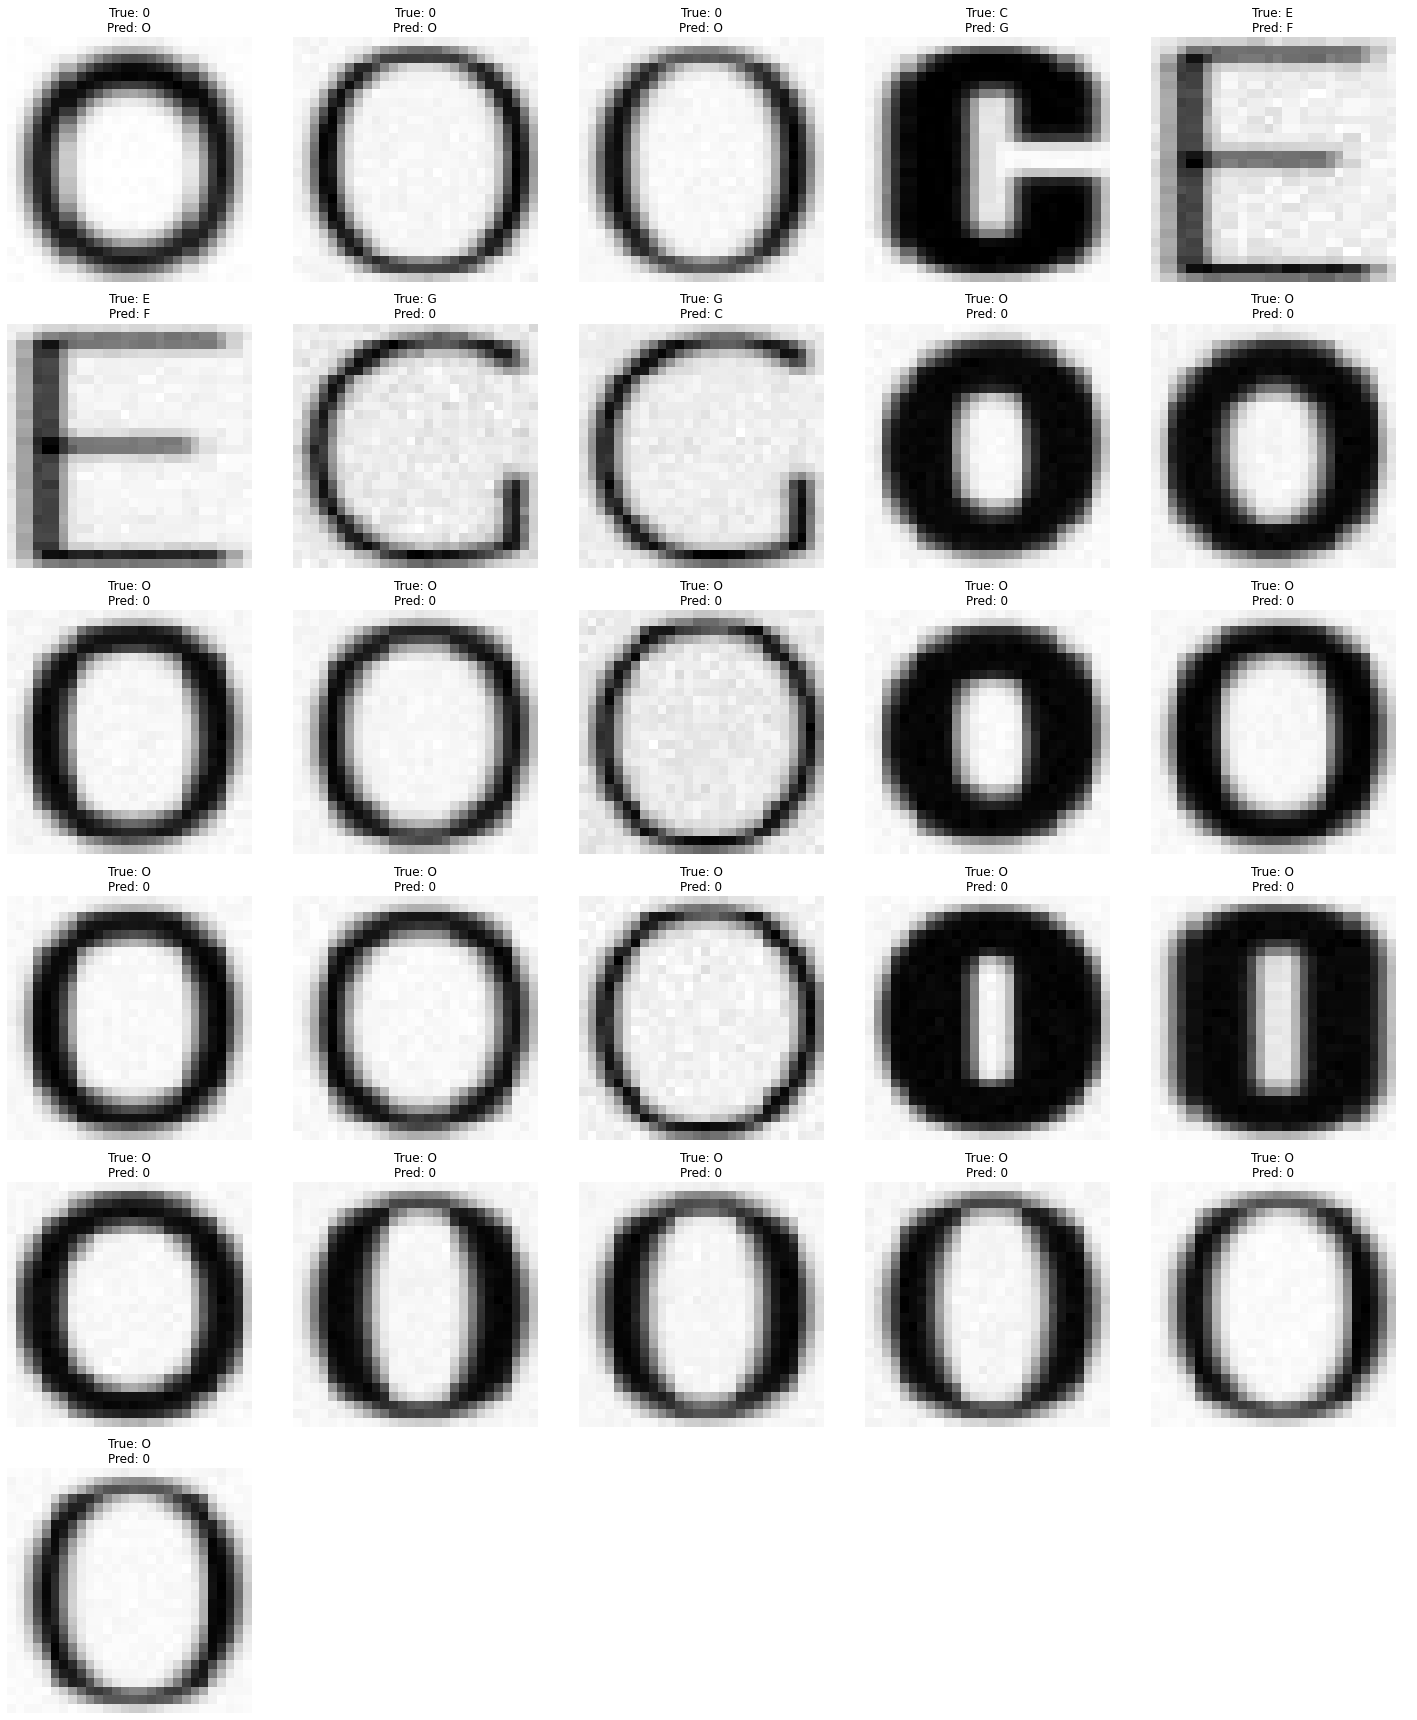

In [25]:
def plot_misclassified_images(test_gen, predictions, true_labels, img_width, img_height):
    misclassified_indices = np.where(predictions != true_labels)[0]
    num_misclassified = len(misclassified_indices)
    print(f'Number of misclassified images: {num_misclassified}')

    if num_misclassified > 0:
        num_columns = 5  # Number of columns for the plot
        num_rows = (num_misclassified + num_columns - 1) // num_columns  # Calculate the number of rows needed

        fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 4, num_rows * 4))
        axes = axes.flatten()

        for img_idx, ax in zip(misclassified_indices, axes):
            img_path = test_gen.filepaths[img_idx]
            img = image.load_img(img_path, target_size=(img_width, img_height), color_mode='grayscale')
            img_array = image.img_to_array(img) / 255.0

            ax.imshow(img_array.squeeze(), cmap='gray')
            ax.axis('off')
            true_label = class_labels[true_labels[img_idx]]
            pred_label = class_labels[predictions[img_idx]]
            ax.set_title(f'True: {true_label}\nPred: {pred_label}')
        
        # Hide any remaining empty subplots
        for ax in axes[num_misclassified:]:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

plot_misclassified_images(test_data_gen, predicted_classes, true_classes, IMG_WIDTH, IMG_HEIGHT)


The predicted character is: S


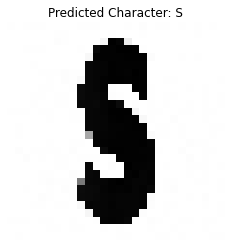

In [26]:
# Define the mapping from class indices to characters
class_indices_to_characters = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'
}

# Load the image
img_path = '/kaggle/input/test-a/s.jpg'  # Ganti dengan path ke gambar baru Anda
img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')

# Convert the image to array
img_array = image.img_to_array(img)

# Normalize the image
img_array = img_array / 255.0

# Reshape the image
img_array = np.reshape(img_array, (1, IMG_HEIGHT, IMG_WIDTH, 1))

# Predict the class of the image
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]

# Convert the predicted class index to the corresponding character
predicted_character = class_indices_to_characters[predicted_class]

# Print the predicted character
print(f'The predicted character is: {predicted_character}')

# Display the image
plt.imshow(img_array[0].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
plt.title(f'Predicted Character: {predicted_character}')
plt.axis('off')
plt.show()


### Convert Model

In [20]:
# Muat model dari file .keras
model = tf.keras.models.load_model('hehe_model.keras')

# Simpan model dalam format .h5
model.save('OCR_final_model.h5')